# Read the data

##### The data can be dound at https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip

##### Metadata about the data is at: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

In [ ]:
! mkdir ./data
! mkdir ./data/zip/
! curl https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip --output data/zip/dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19.6M  100 19.6M    0     0  7487k      0  0:00:02  0:00:02 --:--:-- 7487k


#Make the data into readable csv format

In [ ]:
import zipfile

with zipfile.ZipFile('data/zip/dataset', 'r') as zip_ref:
    zip_ref.extractall('data/')

##### Check if the dataset is created properly

In [ ]:
!ls data/
!ls data/zip

household_power_consumption.txt  zip
dataset


#Importing all the primary libraries

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_percentage_error

# Read the data into pandas dataframe

In [ ]:
household_power_consumption_df = pd.read_csv('data/household_power_consumption.txt', sep=';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
household_power_consumption_df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


#Doing some data exploration

In [ ]:
### Change date and time into one column and make that index

household_power_consumption_df['timestamp'] = pd.to_datetime(household_power_consumption_df['Date'] + ' ' + household_power_consumption_df['Time'], format='%d/%m/%Y %H:%M:%S')

household_power_consumption_df.drop(['Date', 'Time'], inplace=True, axis=1)
household_power_consumption_df.set_index(['timestamp'], inplace=True)


In [ ]:
### Replace the '?' with Nan then convert every column to float 32
household_power_consumption_df.replace('?', np.nan, inplace=True)
household_power_consumption_df = household_power_consumption_df.astype('float32')

In [ ]:
### Fill the missing values with the values from 24 hours prior 
household_power_consumption_df.fillna(household_power_consumption_df.shift(24, freq='H'), inplace=True)

In [ ]:
### Convert minutely data to hourly data as we want to forecast power needs for an hour. Aggregation function used is 'sum'
household_daily_power_consumption_df = household_power_consumption_df.resample('H').sum()

In [ ]:
### Ignoring the first and the last hour as they might not be complete(data might not be available for that complete hour but only part of it)
household_daily_power_consumption_df = household_daily_power_consumption_df[1:-4]

In [ ]:
household_daily_power_consumption_df.loc['2010']

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
timestamp,,,,,,,
2010-01-01 00:00:00,65.152000,5.050,14478.000000,268.600006,0.0,0.0,511.0
2010-01-01 01:00:00,39.074001,8.924,14497.240234,163.399994,0.0,48.0,39.0
2010-01-01 02:00:00,38.076000,6.190,14640.740234,159.199997,0.0,0.0,40.0
2010-01-01 03:00:00,39.180000,4.788,14643.830078,162.400009,0.0,0.0,83.0
2010-01-01 04:00:00,38.764000,8.210,14498.959961,161.199997,0.0,45.0,40.0
...,...,...,...,...,...,...,...
2010-11-26 13:00:00,96.776001,12.392,14313.019531,412.799988,0.0,0.0,1048.0
2010-11-26 14:00:00,84.466003,7.514,14381.419922,351.199982,0.0,0.0,1058.0
2010-11-26 15:00:00,52.585999,6.154,14447.440430,218.599991,0.0,16.0,514.0


#Now we have hourly data for **1441** days. For forecasting we need to come up with a plan to decide the past history that will be used for forecasting, i.e. forecast x hours based on past y hours.  

###Prepare data for training. Based on x hours of data we predict next y hours of data

In [ ]:
def prepare_data_with_past_and_horizon(dataframe, past_history=24, horizon=24):
    '''
    Prepare the training data with past_history (lags) and horizon of prediction steps
    Params:
    dataframe (Pandas dataframe): the dataframe containing the data
    past_history (int): the past history steps to be considered as lags
    horizon (int): steps in future for prediction.   
    '''

    numpy_dataframe = dataframe.to_numpy()
    X = []
    y = []

    for i in range(len(numpy_dataframe) - past_history - horizon + 1):
        X.append([a for a in numpy_dataframe[i:i+past_history]])
        y.append([a for a in numpy_dataframe[i+past_history:i+past_history+horizon]])

    return np.array(X),np.array(y).reshape(len(y),-1)

In [ ]:
X, y = prepare_data_with_past_and_horizon(household_daily_power_consumption_df)

In [ ]:
household_daily_power_consumption_df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
timestamp,,,,,,,
2006-12-16 18:00:00,217.932007,4.802,14074.809570,936.000000,0.0,403.0,1012.0
2006-12-16 19:00:00,204.013992,5.114,13993.950195,870.200012,0.0,86.0,1001.0
2006-12-16 20:00:00,196.113998,4.506,14044.290039,835.000000,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388000,4.600,14229.519531,782.799988,0.0,25.0,1033.0
2006-12-16 22:00:00,132.007996,3.370,14325.599609,571.400024,0.0,8.0,266.0
...,...,...,...,...,...,...,...
2010-11-26 13:00:00,96.776001,12.392,14313.019531,412.799988,0.0,0.0,1048.0
2010-11-26 14:00:00,84.466003,7.514,14381.419922,351.199982,0.0,0.0,1058.0
2010-11-26 15:00:00,52.585999,6.154,14447.440430,218.599991,0.0,16.0,514.0


In [ ]:
print(X.shape)
print(y.shape)

(34537, 24, 7)
(34537, 168)


In [ ]:
X_train, y_train = X[:24984], y[:24984]
X_val, y_val = X[24984:30000], y[24984:30000]
X_test, y_test = X[30000:], y[30000:]

In [ ]:
X_train_temp = X_train.reshape(X_train.shape[0], -1)
X_val_temp = X_val.reshape(X_val.shape[0], -1)
X_test_temp = X_test.reshape(X_test.shape[0], -1)

x_scaler = MinMaxScaler()

X_train_scaled = x_scaler.fit_transform(X_train_temp)
X_val_scaled = x_scaler.transform(X_val_temp)
X_test_scaled = x_scaler.transform(X_test_temp)

X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_val_scaled = X_val_scaled.reshape(X_val.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

y_scaler = MinMaxScaler()

y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
forecasting_model = Sequential()
forecasting_model.add(LSTM(units=200, activation='relu', input_shape=(24,7)))
forecasting_model.add(Dense(24*7))

In [ ]:
forecasting_model.compile(optimizer="adam", loss="mse", metrics="mae")

In [ ]:
forecasting_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               166400    
                                                                 
 dense (Dense)               (None, 168)               33768     
                                                                 
Total params: 200,168
Trainable params: 200,168
Non-trainable params: 0
_________________________________________________________________


In [ ]:
forecasting_model.fit(X_train_scaled, y_train_scaled, epochs = 10, batch_size = 256, validation_data=(X_val_scaled, y_val_scaled))

Epoch 1/10
98/98 [==============================] - 29s 286ms/step - loss: 0.0459 - mae: 0.1310 - val_loss: 0.0318 - val_mae: 0.1068
Epoch 2/10
98/98 [==============================] - 26s 265ms/step - loss: 0.0254 - mae: 0.0973 - val_loss: 0.0296 - val_mae: 0.1030
Epoch 3/10
98/98 [==============================] - 26s 265ms/step - loss: 0.0238 - mae: 0.0926 - val_loss: 0.0275 - val_mae: 0.0979
Epoch 4/10
98/98 [==============================] - 27s 280ms/step - loss: 0.0225 - mae: 0.0890 - val_loss: 0.0261 - val_mae: 0.0950
Epoch 5/10
98/98 [==============================] - 23s 236ms/step - loss: 0.0214 - mae: 0.0857 - val_loss: 0.0258 - val_mae: 0.0925
Epoch 6/10
98/98 [==============================] - 21s 219ms/step - loss: 0.0209 - mae: 0.0846 - val_loss: 0.0256 - val_mae: 0.0929
Epoch 7/10
98/98 [==============================] - 20s 206ms/step - loss: 0.0205 - mae: 0.0832 - val_loss: 0.0249 - val_mae: 0.0914
Epoch 8/10
98/98 [==============================] - 21s 219ms/step - 

In [ ]:
results = forecasting_model.evaluate(X_test_scaled,y_test_scaled, batch_size = 25)

182/182 [==============================] - 3s 16ms/step - loss: 0.0189 - mae: 0.0763


In [ ]:
predictions = forecasting_model.predict(X_test_scaled)

###Analysing the predictions

In [ ]:
predictions_unscaled = y_scaler.inverse_transform(predictions)

In [ ]:
predictions_unscaled = predictions_unscaled.reshape(predictions_unscaled.shape[0], -1, 7)
predictions_unscaled.shape

(4537, 24, 7)

In [ ]:
y_test = y_test.reshape(y_test.shape[0], -1, 7)
y_test.shape

(4537, 24, 7)

###First feature predicted 1 temp step in the future

In [ ]:
import matplotlib.pyplot as plt
def plot_results(predictions_df, title, range_start=0, range_end=200):
    plt.rcParams["figure.figsize"] = (35,10)
    plt.plot(predictions_df['Actual'][range_start:range_end], label='Actual')
    plt.plot(predictions_df['Predicted'][range_start:range_end], label='Predicted')
    plt.xticks(predictions_df.index[range_start:range_end:24])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Observed')
    plt.title(title)

In [ ]:
def verify_results(time_index, y_test, predictions, feature, time_steps_in_horizon, range_start=0, range_end=100):
    predictions_df = pd.DataFrame({'Time': time_index, 'Actual': y_test[:,time_steps_in_horizon,feature], 'Predicted': predictions[:,time_steps_in_horizon,feature]})
    predictions_df.set_index('Time', inplace=True)

    predictions_df = predictions_df[predictions_df['Actual'] > 0]

    mape = mean_absolute_percentage_error(predictions_df['Actual'], predictions_df['Predicted'], multioutput='uniform_average')
    print(f'Mean absolute percentage error: {mape}')

    plot_results(predictions_df, f'Feature {feature}, prediction horizon {time_steps_in_horizon}')

In [ ]:
test_timestamps = household_daily_power_consumption_df.index[30000+24+24-1:]

Mean absolute percentage error: 0.018360288813710213


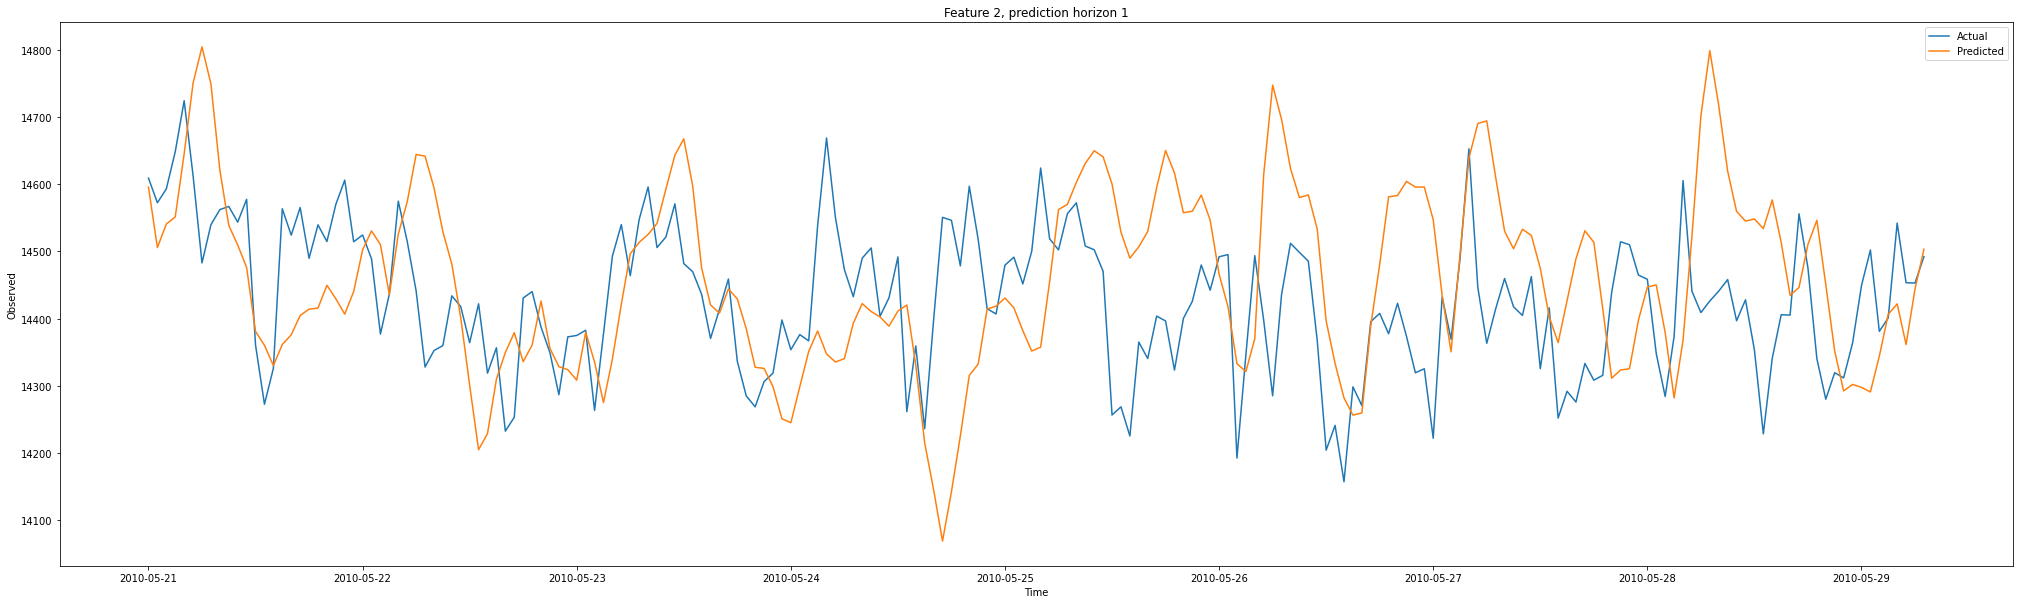

In [ ]:
verify_results(test_timestamps, y_test, predictions_unscaled, feature = 2, time_steps_in_horizon = 1)

In [ ]:
predictions